A lot of the code is from here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/colab_projects/cocoapi/PythonAPI/

/content/drive/MyDrive/colab_projects/cocoapi/PythonAPI


# Imports

In [4]:
import os
import copy

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision.io import read_image
from torchvision import datasets, models, transforms

from tqdm.notebook import trange, tqdm

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
%cd ./utils/
from dataloaders import CocoNoCropping
from config import CATEGORIES_OF_INTEREST; print(CATEGORIES_OF_INTEREST)
# help(CocoNoCropping) # should not be blank
%cd ..

/content/drive/MyDrive/colab_projects/cocoapi/PythonAPI/utils
['bird', 'cat', 'dog', 'person']
/content/drive/MyDrive/colab_projects/cocoapi/PythonAPI


# Transforms, Datasets, and Data Loaders

In [7]:
# # Data augmentation and normalization for training
# # Just normalization for validation
# data_transforms = {
#     'train1': transforms.Compose([
#         transforms.Resize(size=(224, 224)),
#         transforms.RandomHorizontalFlip(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'dev': transforms.Compose([
#         transforms.Resize(size=(224, 224)),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

# data_dir = 'data/hymenoptera_data'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

In [8]:
train_transforms = torch.nn.Sequential(
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(), # simple augmentation
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet constants
)

dev_transforms = torch.nn.Sequential(
    transforms.Resize(size=(224, 224)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet constants
)

In [9]:
train1_dataset = CocoNoCropping(
    img_ids = '../my_splits/train1_ids.txt',
    my_annotations_file = '../my_annotations/imgIds_to_labels_train2017.json',
    img_dir = '../my_images/train1/',
    transform=train_transforms,
    divide_by_255=True
)

dev1_dataset = CocoNoCropping(
    img_ids = '../my_splits/dev1_ids.txt',
    my_annotations_file = '../my_annotations/imgIds_to_labels_train2017.json',
    img_dir = '../my_images/dev1/',
    transform=dev_transforms,
    divide_by_255=True
)

In [10]:
# droplast since the number of images is likely not to be divisible by batch_size
train1_dataloader = DataLoader(train1_dataset, batch_size=32, shuffle=True, drop_last=True)
dev1_dataloader = DataLoader(dev1_dataset, batch_size=32, shuffle=False, drop_last=True)

# Visualize a few images

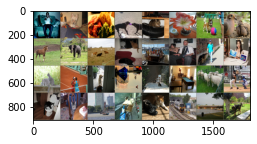

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
bird,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
cat,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0
dog,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
person,1,1,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1


In [11]:
fig, ax = plt.subplots(figsize=(18, 2))
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    
    # ImageNet constants
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
batch = next(iter(train1_dataloader))
inputs, labels = batch['image'], batch['label']

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

pd.DataFrame({CATEGORIES_OF_INTEREST[i]: labels[i].numpy() for i in range(len(labels))}).T

# Training and Validation Loops

In [19]:
def train_one_epoch(iterator, model, criterion, optimizer):
    total = 0
    epoch_loss = 0
    per_class_correct = torch.zeros(4)
    
    for batch in tqdm(iterator, desc='train'):
        model.train()

        inputs = batch['image'].to(device) # [batch size, channel, h, w]
        #print(inputs.shape, inputs.dtype)
        # right now, `labels` is a list with num_classes tensors, each tensor with batch_size of labels (integers)
        labels = torch.vstack(batch['label']).T.contiguous().to(torch.float32).to(device)
        #print(labels.shape, labels.dtype, labels.is_contiguous()) # labels
        total += labels.shape[0]
        
        optimizer.zero_grad()

        outputs = model(inputs) #logits
        #print(outputs.shape, outputs.dtype, outputs.is_contiguous())
        #print(outputs)

        loss = criterion(outputs, labels)
        epoch_loss += loss.item() # no need to drag 
        #print(loss.item())

        loss.backward()
        optimizer_ft.step()

        preds = (outputs > 0.5).detach().to(torch.int32) # no need to drag the gradients
        #print(preds)
        per_class_correct += (preds.cpu() == labels.cpu()).sum(0) # 0-th axis for batch_size
        #print(per_class_correct)
    
    avg_epoch_loss = epoch_loss / total
    avg_per_class_acc = per_class_correct / total
    
    return avg_epoch_loss, avg_per_class_acc

In [20]:
def evaluate(iterator, model, criterion):
    total = 0
    epoch_loss = 0
    per_class_correct = torch.zeros(4)
    
    for batch in tqdm(iterator, desc='dev'):
        
        # no need for gradients, batch-norm and dropout in evaluation mode
        model.eval()
        with torch.no_grad():
            
            inputs = batch['image'].to(device) # [batch size, channel, h, w]
            #print(inputs.shape, inputs.dtype)
            # right now, `labels` is a list with num_classes tensors, each tensor with batch_size of labels (integers)
            labels = torch.vstack(batch['label']).T.contiguous().to(torch.float32).to(device)
            #print(labels.shape, labels.dtype, labels.is_contiguous()) # labels
            total += labels.shape[0]

            outputs = model(inputs) #logits
            #print(outputs.shape, outputs.dtype, outputs.is_contiguous())
            #print(outputs)

            loss = criterion(outputs, labels)
            epoch_loss += loss.item() # no need to drag 
            #print(loss.item())

            preds = (outputs > 0.5).detach().to(torch.int32) # no need to drag the gradients
            #print(preds)
            per_class_correct += (preds.cpu() == labels.cpu()).sum(0) # 0-th axis for batch_size
            #print(per_class_correct)
    
    avg_epoch_loss = epoch_loss / total
    avg_per_class_acc = per_class_correct / total
    
    return avg_epoch_loss, avg_per_class_acc

# Fine-tune only the last layer

In [21]:
device

'cuda:0'

In [22]:
# load pre-trained model
model_ft = models.resnet18(pretrained=True)

# freese all parameters initially
for param in model_ft.parameters():
    param.requires_grad = False
    
# unfreeeze model parameters of the last layer
for param in model_ft.fc.parameters():
    param.requires_grad = True

# replace the last layer to fit the task
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Linear(num_ftrs, len(CATEGORIES_OF_INTEREST))

# place it on the device
model_ft = model_ft.to(device)

criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

In [23]:
#model_ft


Train Avg Acc: 0.7738281488418579
Train Loss: 2.6142415583133696
Train Accs per class: tensor([0.8000, 0.8406, 0.7391, 0.7156])




Dev Avg Acc: 0.8187499642372131
Dev Loss: 2.5855101138353347
Dev Accs per class: tensor([0.8516, 0.8922, 0.7937, 0.7375])


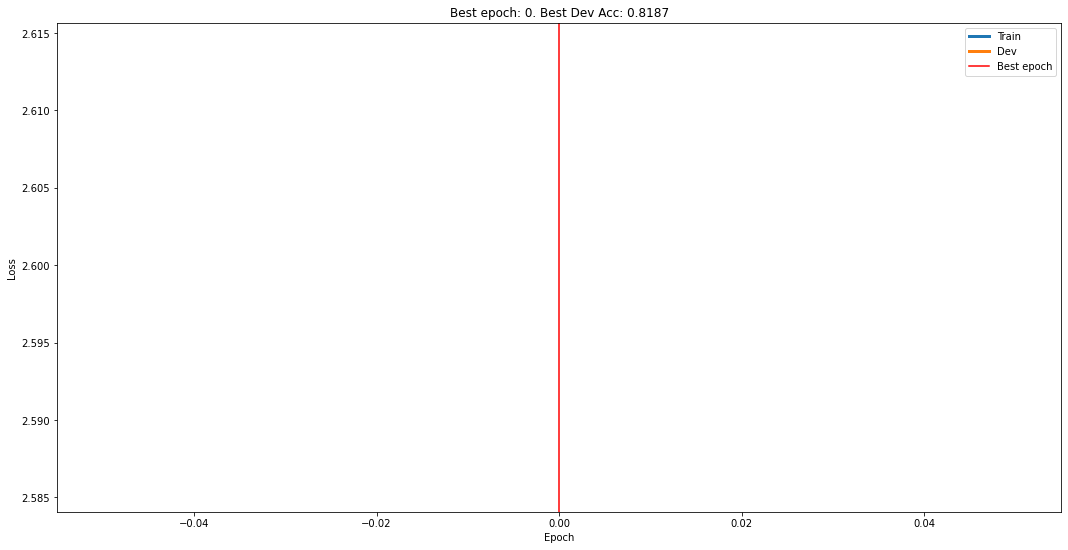


--------------------------------------------------------------------------------




Train Avg Acc: 0.8304687738418579
Train Loss: 2.3457489132881166
Train Accs per class: tensor([0.8469, 0.8906, 0.8281, 0.7563])




Dev Avg Acc: 0.8296875357627869
Dev Loss: 2.3230919361114504
Dev Accs per class: tensor([0.8422, 0.8625, 0.7891, 0.8250])


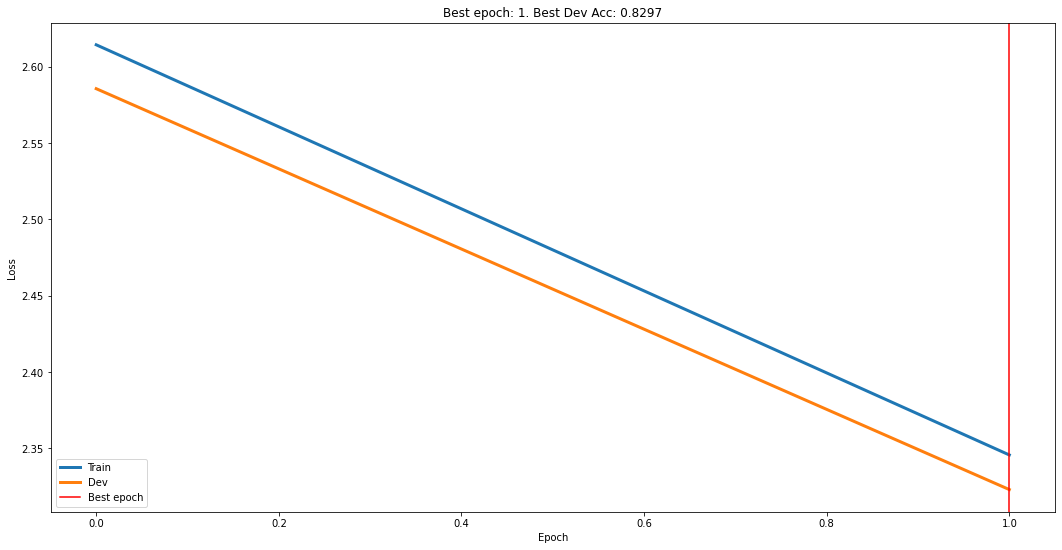


--------------------------------------------------------------------------------




Train Avg Acc: 0.896484375
Train Loss: 1.1703059822320938
Train Accs per class: tensor([0.9078, 0.9266, 0.8859, 0.8656])




Dev Avg Acc: 0.856640636920929
Dev Loss: 1.891848650574684
Dev Accs per class: tensor([0.8422, 0.8844, 0.8453, 0.8547])


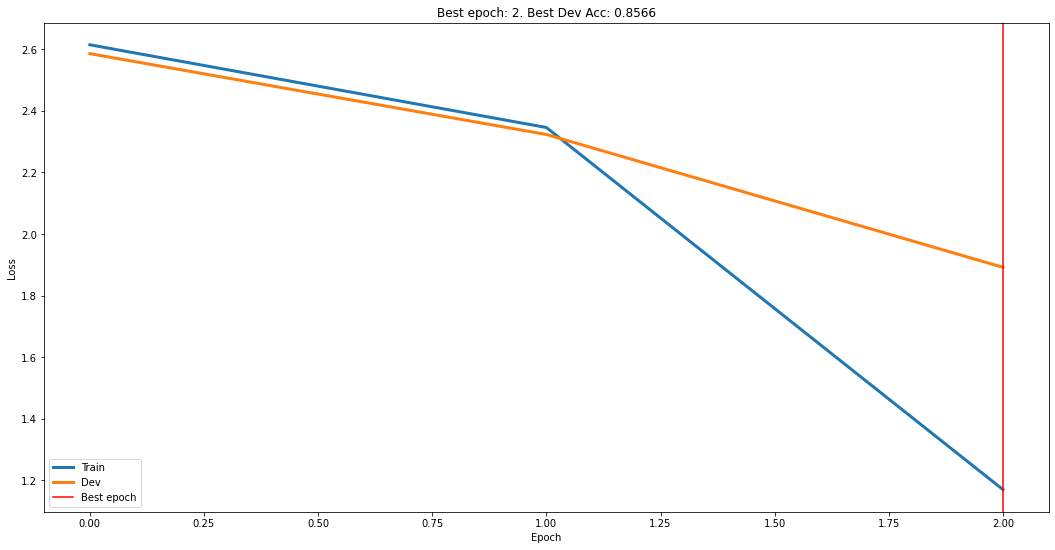


--------------------------------------------------------------------------------




Train Avg Acc: 0.8921874761581421
Train Loss: 1.135844987630844
Train Accs per class: tensor([0.8797, 0.9172, 0.8984, 0.8734])




Dev Avg Acc: 0.8519531488418579
Dev Loss: 1.8164659053087235
Dev Accs per class: tensor([0.8344, 0.8859, 0.8391, 0.8484])


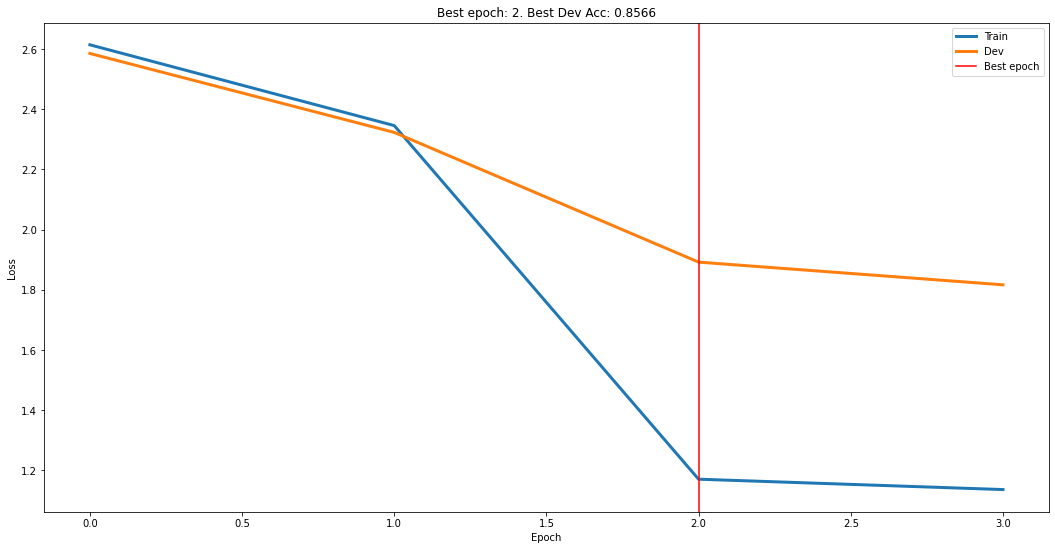


--------------------------------------------------------------------------------


CPU times: user 51.6 s, sys: 2.67 s, total: 54.2 s
Wall time: 6min 30s


In [24]:
%%time

num_epochs = 4
train_epoch_loss_history = []
train_per_class_acc_history = []

dev_epoch_loss_history = []
dev_per_class_acc_history = []

dev_epoch_acc_history = []

best_acc = None
best_epoch = None

best_model_wts = copy.deepcopy(model_ft.state_dict())

for epoch in trange(num_epochs, desc='epoch'):
    # train
    avg_epoch_loss, avg_per_class_acc = train_one_epoch(iterator=train1_dataloader,
                                                        model=model_ft, criterion=criterion,
                                                        optimizer=optimizer_ft)
    avg_acc = avg_per_class_acc.mean().item()
    print('Train Avg Acc:', avg_acc)
    train_epoch_loss_history.append(avg_epoch_loss)
    train_per_class_acc_history.append(avg_per_class_acc)
    print('Train Loss:', avg_epoch_loss)
    print('Train Accs per class:', avg_per_class_acc)
    print()
    
    # evaluate on the dev set
    avg_epoch_loss, avg_per_class_acc = evaluate(iterator=dev1_dataloader,
                                                 model=model_ft, criterion=criterion)
    avg_acc = avg_per_class_acc.mean().item()
    print('Dev Avg Acc:', avg_acc)
    dev_epoch_loss_history.append(avg_epoch_loss)
    dev_per_class_acc_history.append(avg_per_class_acc)
    print('Dev Loss:', avg_epoch_loss)
    print('Dev Accs per class:', avg_per_class_acc)
    
    dev_epoch_acc_history.append(avg_acc)
        
    if (not best_acc) or avg_acc > best_acc:
        best_epoch = epoch
        best_acc = avg_acc
        
        best_model_wts = copy.deepcopy(model_ft.state_dict())

    # lr scheduler step
    exp_lr_scheduler.step()

    # plot
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_epoch_loss_history)), train_epoch_loss_history, label=f'Train', linewidth=3)
    plt.plot(np.arange(len(dev_epoch_loss_history)), dev_epoch_loss_history, label=f'Dev', linewidth=3)
    plt.axvline(x=best_epoch, label='Best epoch', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Best epoch: {best_epoch}. Best Dev Acc: {best_acc:.4}')
    plt.legend(loc='best')
    plt.show()


    print()
    print('-'*80)
    print()

# Fine-tune all layers with lower learning rate

In [ ]:
device

'cuda:0'

In [25]:
# unfreese all parameters initially
for param in model_ft.parameters():
    param.requires_grad = True

criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)


Train Avg Acc: 0.8804687857627869
Train Loss: 1.2775593638420104
Train Accs per class: tensor([0.8984, 0.8984, 0.8766, 0.8484])




Dev Avg Acc: 0.8035156726837158
Dev Loss: 2.541388285160065
Dev Accs per class: tensor([0.8125, 0.8734, 0.8156, 0.7125])


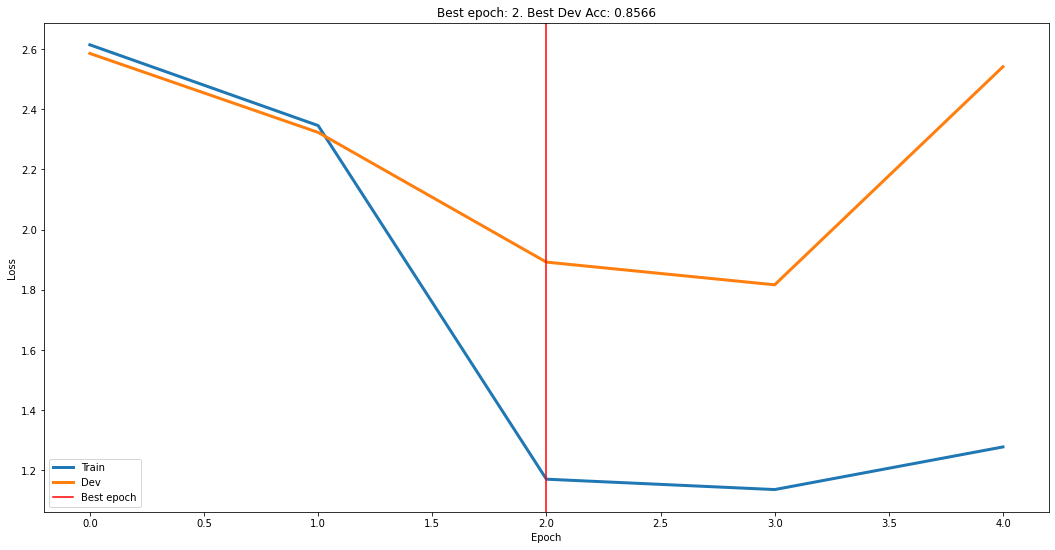


--------------------------------------------------------------------------------




Train Avg Acc: 0.9386718273162842
Train Loss: 0.6366109430789948
Train Accs per class: tensor([0.9391, 0.9547, 0.9172, 0.9438])




Dev Avg Acc: 0.8382812738418579
Dev Loss: 2.135502102971077
Dev Accs per class: tensor([0.8422, 0.8766, 0.7922, 0.8422])


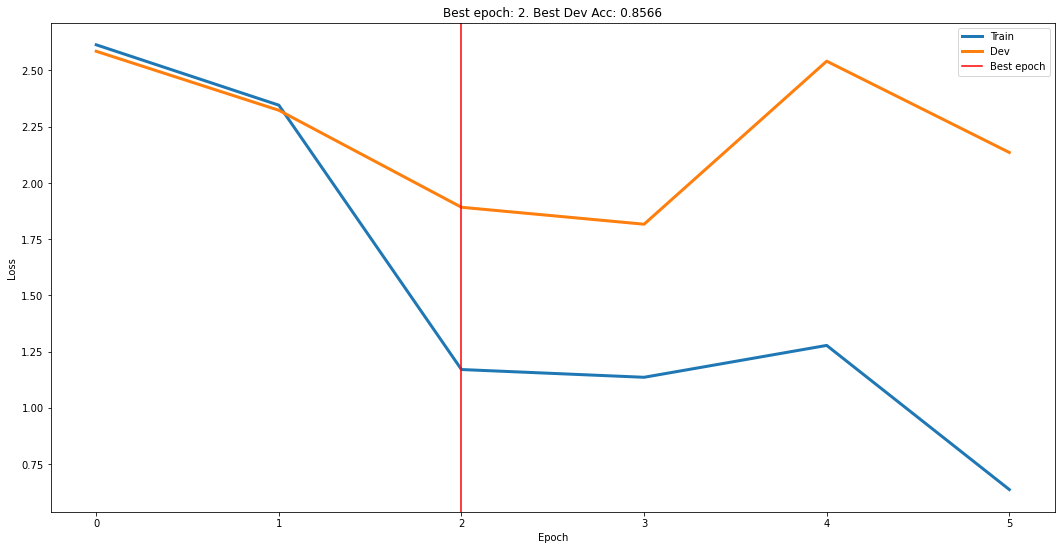


--------------------------------------------------------------------------------




Train Avg Acc: 0.9613281488418579
Train Loss: 0.40824377685785296
Train Accs per class: tensor([0.9797, 0.9578, 0.9625, 0.9453])




Dev Avg Acc: 0.841796875
Dev Loss: 2.1428960129618644
Dev Accs per class: tensor([0.8297, 0.8844, 0.8234, 0.8297])


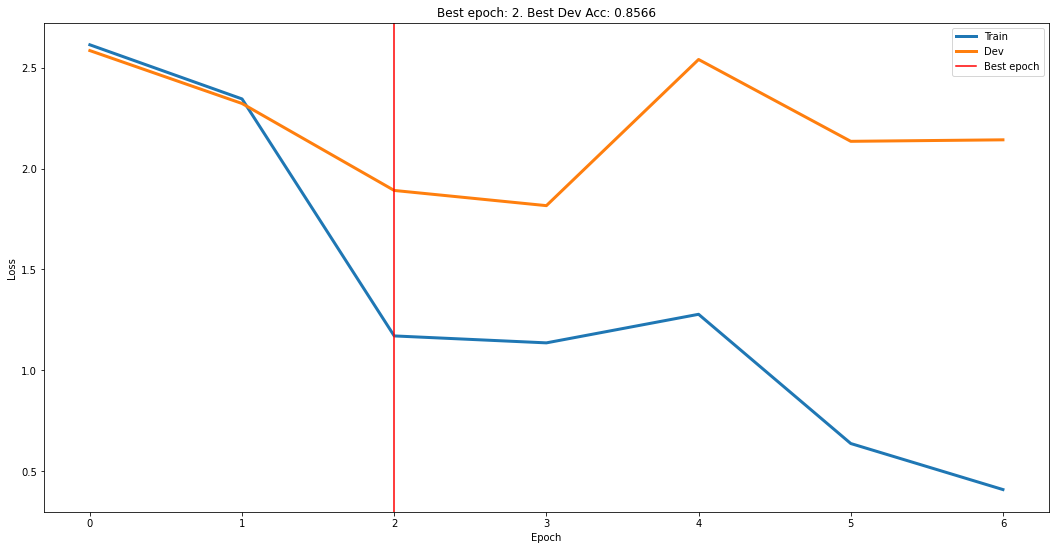


--------------------------------------------------------------------------------




Train Avg Acc: 0.9800781607627869
Train Loss: 0.22588192261755466
Train Accs per class: tensor([0.9906, 0.9750, 0.9828, 0.9719])




Dev Avg Acc: 0.8558593392372131
Dev Loss: 2.107519567012787
Dev Accs per class: tensor([0.8469, 0.8797, 0.8266, 0.8703])


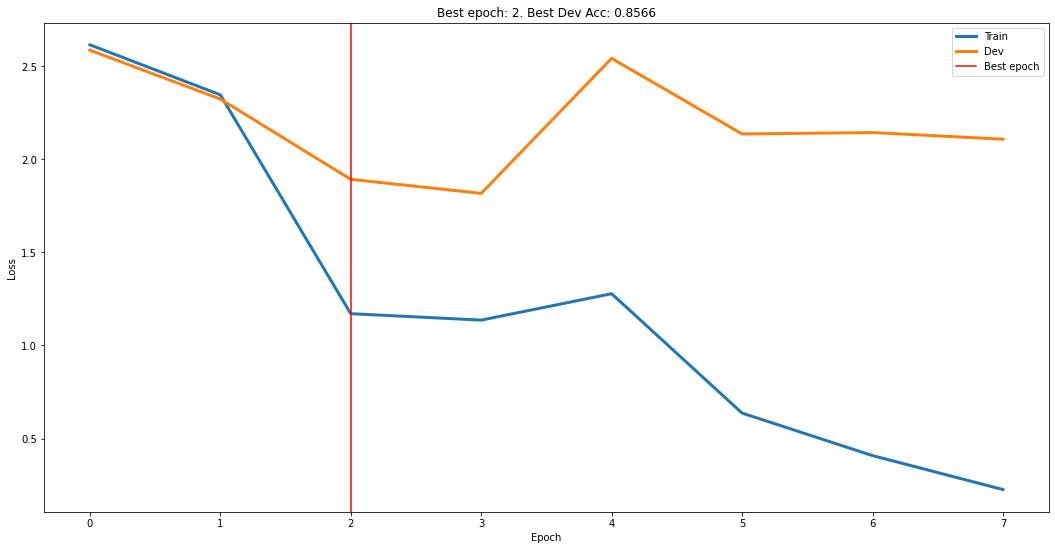


--------------------------------------------------------------------------------




Train Avg Acc: 0.9867187738418579
Train Loss: 0.1443756466731429
Train Accs per class: tensor([0.9906, 0.9891, 0.9906, 0.9766])




Dev Avg Acc: 0.8425780534744263
Dev Loss: 2.3313237100839617
Dev Accs per class: tensor([0.8391, 0.8906, 0.8062, 0.8344])


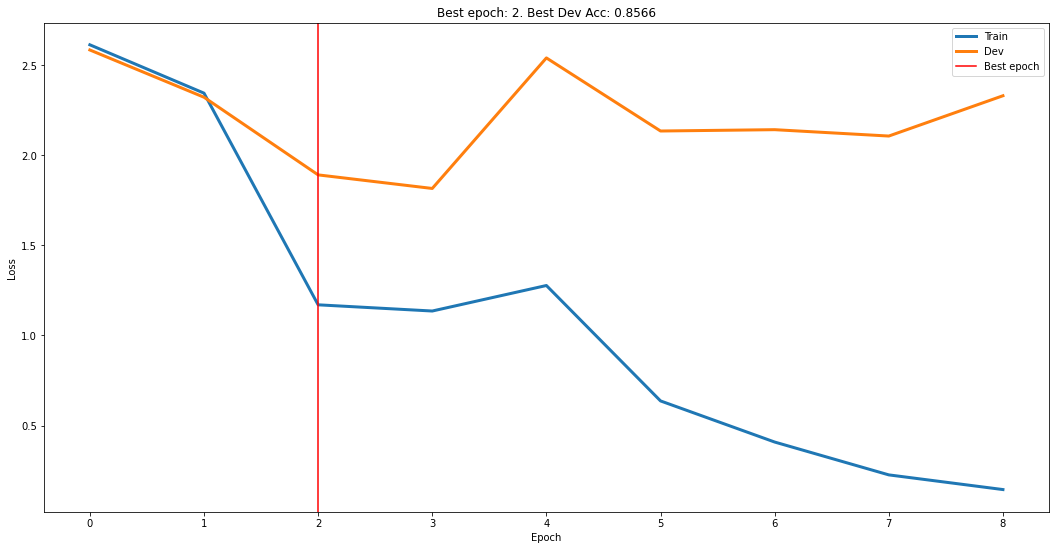


--------------------------------------------------------------------------------




Train Avg Acc: 0.9945312738418579
Train Loss: 0.08871133960783481
Train Accs per class: tensor([0.9984, 0.9922, 0.9969, 0.9906])




Dev Avg Acc: 0.846875011920929
Dev Loss: 2.16981754899025
Dev Accs per class: tensor([0.8375, 0.8938, 0.8094, 0.8469])


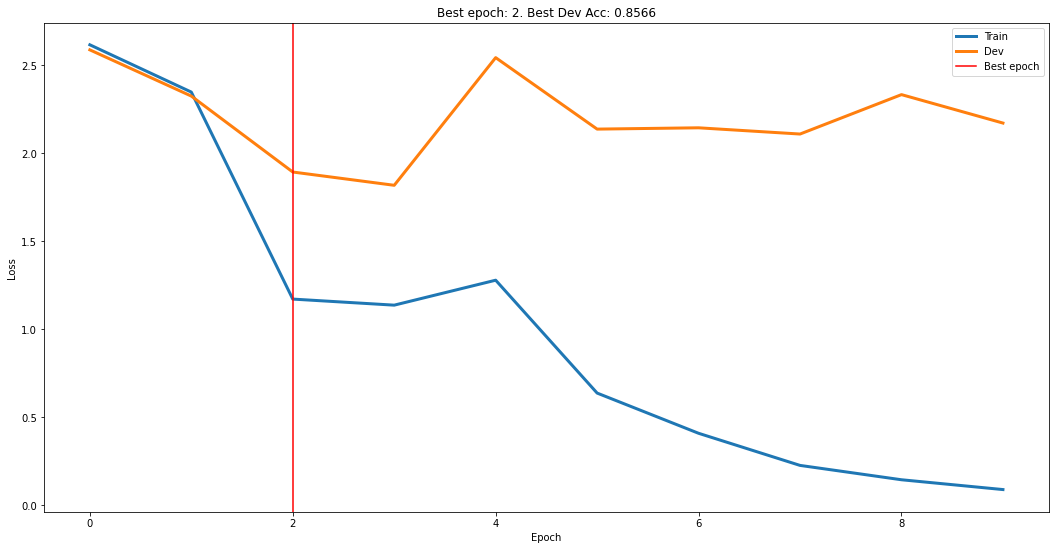


--------------------------------------------------------------------------------




Train Avg Acc: 0.994140625
Train Loss: 0.07173044141381979
Train Accs per class: tensor([0.9937, 0.9922, 0.9953, 0.9953])




Dev Avg Acc: 0.848828136920929
Dev Loss: 2.147934852540493
Dev Accs per class: tensor([0.8359, 0.8906, 0.8125, 0.8562])


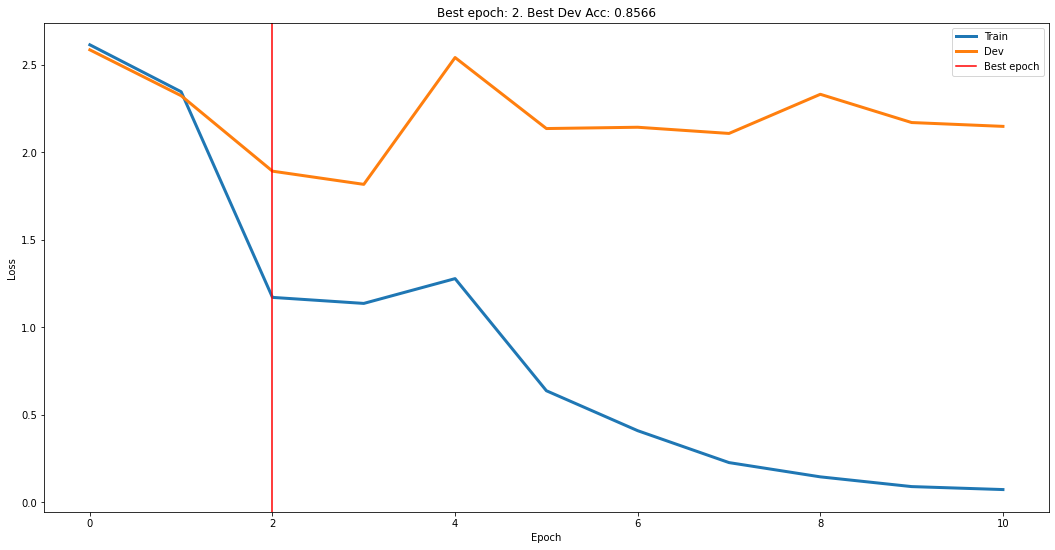


--------------------------------------------------------------------------------




Train Avg Acc: 0.9949219226837158
Train Loss: 0.08406079793348908
Train Accs per class: tensor([0.9984, 0.9984, 1.0000, 0.9828])




Dev Avg Acc: 0.8515625
Dev Loss: 2.0972926378250123
Dev Accs per class: tensor([0.8375, 0.8922, 0.8156, 0.8609])


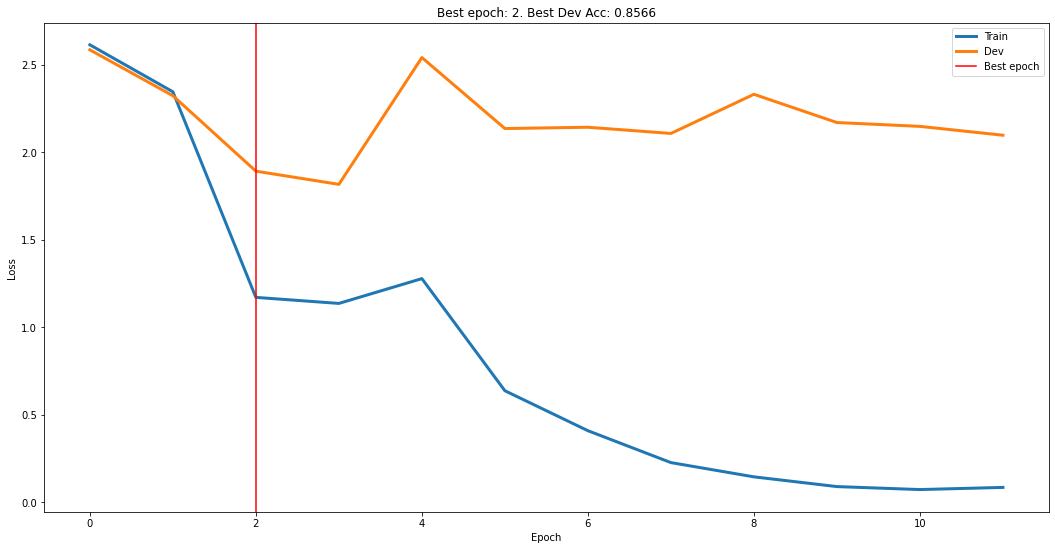


--------------------------------------------------------------------------------




Train Avg Acc: 0.995312511920929
Train Loss: 0.07149171391502022
Train Accs per class: tensor([0.9969, 0.9984, 0.9891, 0.9969])




Dev Avg Acc: 0.850390613079071
Dev Loss: 2.0990393340587614
Dev Accs per class: tensor([0.8391, 0.8938, 0.8125, 0.8562])


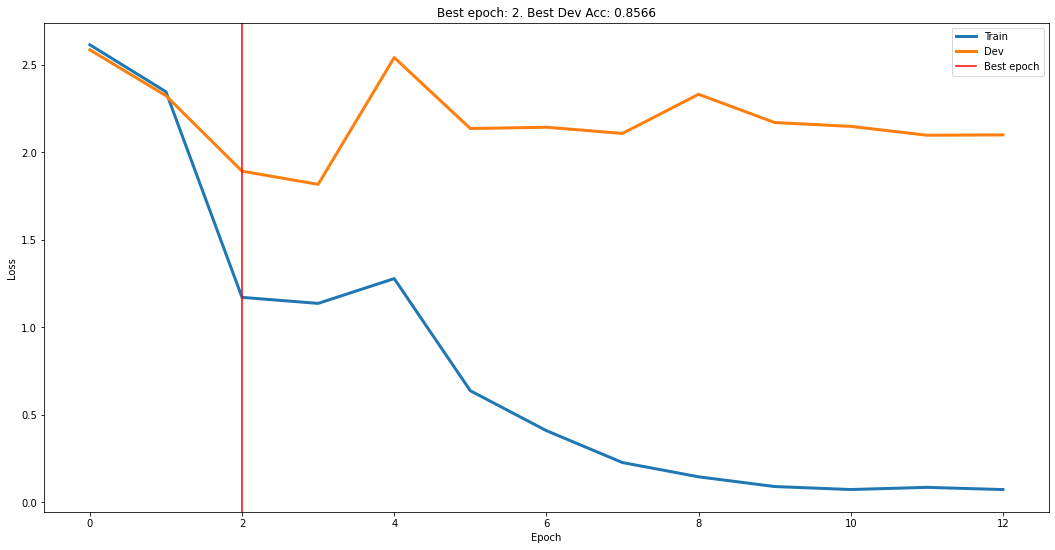


--------------------------------------------------------------------------------




Train Avg Acc: 0.998046875
Train Loss: 0.04899858608841896
Train Accs per class: tensor([0.9984, 0.9984, 0.9953, 1.0000])




Dev Avg Acc: 0.8515625596046448
Dev Loss: 2.1247863590717317
Dev Accs per class: tensor([0.8359, 0.8953, 0.8188, 0.8562])


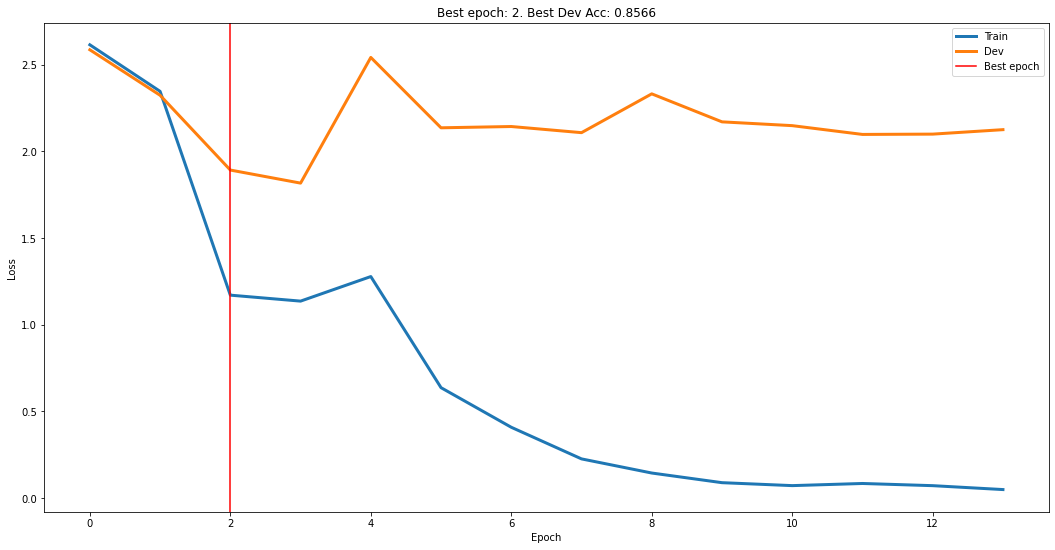


--------------------------------------------------------------------------------




In [26]:
num_epochs = 10

for epoch in trange(num_epochs, desc='epoch'):
    # train
    avg_epoch_loss, avg_per_class_acc = train_one_epoch(iterator=train1_dataloader,
                                                        model=model_ft, criterion=criterion,
                                                        optimizer=optimizer_ft)
    avg_acc = avg_per_class_acc.mean().item()
    print('Train Avg Acc:', avg_acc)
    train_epoch_loss_history.append(avg_epoch_loss)
    train_per_class_acc_history.append(avg_per_class_acc)
    print('Train Loss:', avg_epoch_loss)
    print('Train Accs per class:', avg_per_class_acc)
    print()
    
    # evaluate on the dev set
    avg_epoch_loss, avg_per_class_acc = evaluate(iterator=dev1_dataloader,
                                                 model=model_ft, criterion=criterion)
    avg_acc = avg_per_class_acc.mean().item()
    print('Dev Avg Acc:', avg_acc)
    dev_epoch_loss_history.append(avg_epoch_loss)
    dev_per_class_acc_history.append(avg_per_class_acc)
    print('Dev Loss:', avg_epoch_loss)
    print('Dev Accs per class:', avg_per_class_acc)
    
    dev_epoch_acc_history.append(avg_acc)
        
    if (not best_acc) or avg_acc > best_acc:
        best_epoch = epoch
        best_acc = avg_acc
        
        best_model_wts = copy.deepcopy(model_ft.state_dict())

    # lr scheduler step
    exp_lr_scheduler.step()

    # plot
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_epoch_loss_history)), train_epoch_loss_history, label=f'Train', linewidth=3)
    plt.plot(np.arange(len(dev_epoch_loss_history)), dev_epoch_loss_history, label=f'Dev', linewidth=3)
    plt.axvline(x=best_epoch, label='Best epoch', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Best epoch: {best_epoch}. Best Dev Acc: {best_acc:.4}')
    plt.legend(loc='best')
    plt.show()


    print()
    print('-'*80)
    print()

In [29]:
%mkdir ../weights

In [30]:
torch.save(model_ft.state_dict(), '../weights/baseline-2021-06-09.pth')

In [31]:
%ls ../weights

baseline-2021-06-09.pth
